In [12]:
#Install all dependencies
!pip install sktime[dl]
!pip install pandas
!pip install numpy==1.26.4
!pip install seaborn

In [13]:
#Import Pandas and numpy for dataset filtering
import pandas as pd
import numpy as np

df = pd.read_csv('features_df_10s_3s.csv')
df['subject_trial'] = df['subject'].astype(str)+'_'+df['trial'].astype(str)
df_filt = df.drop(['subject','trial'], axis=1)
df_filt

,activity,window,acc_x_mean,acc_x_std,acc_x_ptp,acc_x_skew,acc_x_kurtosis,acc_x_max,acc_x_min,acc_x_rms,...,gyro_z_std,gyro_z_ptp,gyro_z_skew,gyro_z_kurtosis,gyro_z_max,gyro_z_min,gyro_z_rms,gyro_z_dom_freq,gyro_z_dom_power,subject_trial
0,downstairs,0,-0.023998,0.283579,2.313090,-0.389540,2.053978,1.087611,-1.225479,0.284593,...,0.702851,4.235752,0.401193,0.628829,2.484049,-1.751703,0.730917,1.0,7731.701629,sub_1_dws_2
1,downstairs,1,-0.031795,0.272414,2.094176,-0.362455,1.670366,0.868698,-1.225479,0.274263,...,0.637546,3.888201,-0.066714,0.607222,2.102682,-1.785519,0.660403,2.5,3244.326669,sub_1_dws_2
2,downstairs,2,-0.034379,0.269779,2.094176,-0.439600,2.064346,0.868698,-1.225479,0.271960,...,0.682044,4.078817,0.223416,0.457288,2.293299,-1.785519,0.711465,1.0,6322.854542,sub_1_dws_2
3,downstairs,3,-0.043502,0.250859,1.744506,-0.026250,0.722650,0.726684,-1.017823,0.254603,...,0.594518,4.078817,0.101985,1.195871,2.293299,-1.785519,0.617263,2.0,2660.482244,sub_1_dws_2
4,downstairs,4,-0.042466,0.251274,1.744506,-0.124765,0.810124,0.726684,-1.017823,0.254837,...,0.623529,3.760722,0.380127,0.777102,2.293299,-1.467423,0.656145,1.0,5630.895696,sub_1_dws_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,jogging,11,-0.440813,1.302159,6.795539,-0.085905,-0.148493,2.561716,-4.233823,1.374749,...,4.188105,16.636163,-0.151476,-0.936434,7.970609,-8.665554,4.188106,1.5,835012.656032,sub_24_jog_9
8399,jogging,12,-0.417209,1.323180,6.795539,-0.077697,-0.212170,2.561716,-4.233823,1.387396,...,4.250813,17.235981,-0.176997,-0.908589,7.970609,-9.265371,4.250814,1.5,780853.568846,sub_24_jog_9
8400,jogging,13,-0.437166,1.325953,6.580567,-0.106665,-0.161256,2.561716,-4.018851,1.396161,...,4.216708,17.235981,-0.218805,-0.873383,7.970609,-9.265371,4.218669,2.9,541263.179172,sub_24_jog_9
8401,jogging,14,-0.424587,1.320178,6.483155,-0.130750,-0.162647,2.464304,-4.018851,1.386774,...,4.243302,17.112873,-0.147880,-0.941098,7.847502,-9.265371,4.243685,1.4,696759.180718,sub_24_jog_9


In [14]:
# Padding and Trimming so window length is same across different subjects
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested

window_lengths = df_filt.groupby('subject_trial').size()
target_length = int(window_lengths.mean())
print("Target Length "+str(target_length))
samples = []
labels = []
subject_trials = []

for subject_trial in df_filt['subject_trial'].unique():
    # Get window data
    window_mask = df_filt['subject_trial'] == subject_trial
    window_data = df_filt[window_mask]
    
    # Separate features and labels
    features = window_data.drop(['subject_trial', 'activity'], axis=1)
    label = window_data['activity'].iloc[0]  # All rows have same activity
    
    # Convert to (features, timesteps) format
    window_array = features.values.T
    current_length = window_array.shape[1]
    
    # Trim or pad to target length
    if current_length > target_length:
        # Trim if too long
        window_array = window_array[:, :target_length]
    elif current_length < target_length:
        # Pad if too short (using edge values)
        pad_width = target_length - current_length
        last_values = window_array[:, -1:]  # Get last values
        padding = np.repeat(last_values, pad_width, axis=1)
        window_array = np.concatenate([window_array, padding], axis=1)
    
    samples.append(window_array)
    labels.append(label)
    subject_trials.append(subject_trial)

# Convert to 3D numpy array (samples, features, timesteps)
X_3d = np.array(samples)
y_labels = np.array(labels)
print("output X array shape: "+str(X_3d.shape))

Target Length 23
output X array shape: (358, 61, 23)


In [15]:
# Convert to sktime nested DataFrame
X_series = from_3d_numpy_to_nested(X_3d)

# Set the subject_trial as index
X_series.index = subject_trials

# Create y series with same index
y_series = pd.Series(y_labels, index=subject_trials, name='activity')
X_series.shape, y_series.shape

((358, 61), (358,))

In [16]:
#Defining Training and Testing Sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 61), (250,), (108, 61), (108,))

In [17]:
#Train MLP Classifier over curated dataset
from sktime.classification.deep_learning.mlp import MLPClassifier
mlp = MLPClassifier(n_epochs=100,batch_size=64, random_state=42)  
mlp.fit(X_train, y_train)

MLPClassifier(batch_size=64, n_epochs=100, random_state=42)

In [18]:
#Carry out predictions and evaluate performance for MLP Classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = mlp.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022AE67956C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0.2037037037037037
              precision    recall  f1-score   support

  downstairs       0.00      0.00      0.00        24
     jogging       0.00      0.00      0.00        14
     sitting     

C:\Users\shrey\anaconda3\envs\neuro\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shrey\anaconda3\envs\neuro\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shrey\anaconda3\envs\neuro\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

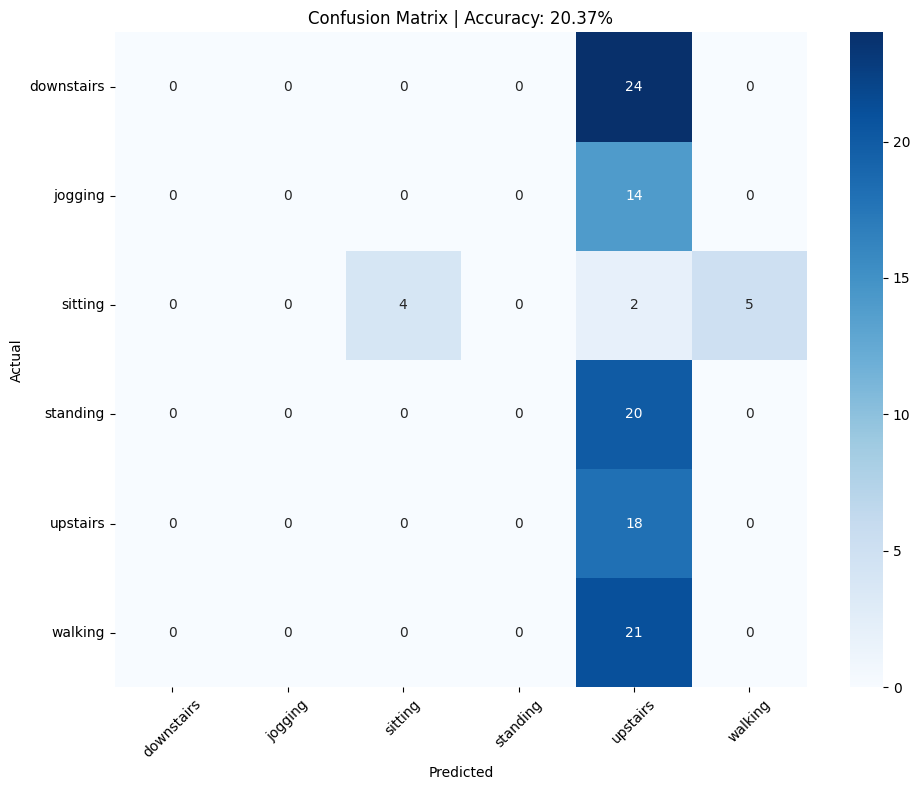

In [19]:
#Plot Confusion Matrix for MLP Classifier
import matplotlib.pyplot as plt
import seaborn as sns
class_names = ['downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']

accuracy_mlp = accuracy_score(y_test, y_pred)
cm_mlp = confusion_matrix(y_test, y_pred)

# Create the heatmap with label names
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix | Accuracy: {accuracy_mlp:.2%}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
#Train LSTMFCNN Classifier for better performance
from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier
lstmfcn = LSTMFCNClassifier(n_epochs=100,batch_size=64, random_state=42)  
lstmfcn.fit(X_train, y_train)

LSTMFCNClassifier(batch_size=64, n_epochs=100, random_state=42)

In [21]:
#Carry out predictions and evaluate performance for LSTMFCNN Classifier
y_pred = lstmfcn.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
0.8148148148148148
              precision    recall  f1-score   support

  downstairs       1.00      0.79      0.88        24
     jogging       1.00      0.93      0.96        14
     sitting       0.46      1.00      0.63        11
    standing       1.00      0.35      0.52        20
    upstairs       0.86      1.00      0.92        18
     walking       0.83      0.95      0.89        21

    accuracy                           0.81       108
   macro avg       0.86      0.84      0.80       108
weighted avg       0.89      0.81      0.81       108



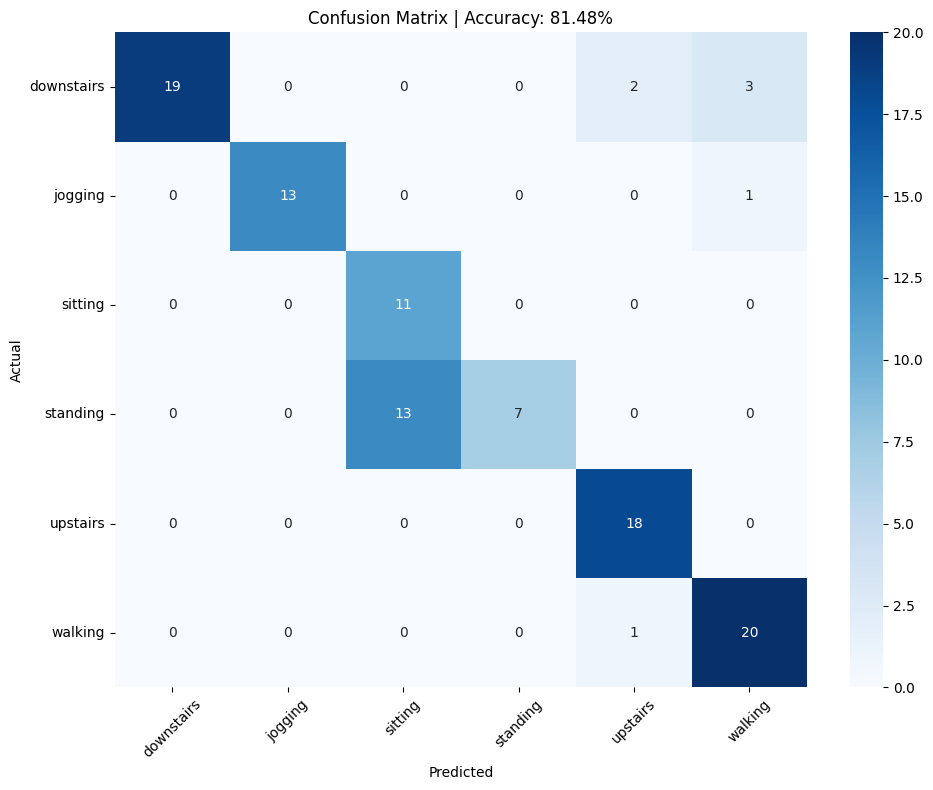

In [22]:
# Create the heatmap for LSTMFCNN Score with label names to see improvement
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix | Accuracy: {accuracy:.2%}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
## Now perform the same using MACNN  
Use the `MACNNClassifier` implementation from `sktime`.  
[MACNNClassifier documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.deep_learning.macnn.MACNNClassifier.html)